# Plot rastergram of single-subject, single-channel, single-band LFP power

This plot demonstrates the reliability of peri-stop power increases across trials.

In [1]:
import numpy as np
import pandas as pd
import physutils
import dbio
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# patient, dataset, channel
dtup = 18, 1, 22

In [3]:
# load data
dbname = os.path.expanduser('data/bart.hdf5')
lfp = dbio.fetch_all_such_LFP(dbname, *dtup)

# remove global mean
if lfp.shape[1] > 1:
    lfp = lfp.demean_global()


In [4]:
# bandpass filter
bands = ['theta']
lfp = lfp.bandlimit(bands)

# decimate to 40 Hz effective sampling
lfp = lfp.decimate(5)

# instantaneous power
lfp = lfp.instpwr()

# remove censored regions
lfp = lfp.censor()

# rolling smooth
lfp = lfp.smooth(0.075)

# convert to dB
lfp = lfp.apply(lambda x: 10 * np.log10(x))

In [5]:
# get events
evt = dbio.fetch(dbname, 'events', *dtup[:-1])
t_evt = evt[['start inflating', 'banked', 'popped']].copy()

In [6]:
# calculate duration of inflation on each trial

# first, make a series including all stop times
# this uses the trick that the mean() method ignores NaNs to merge columns
t_evt['stop inflating'] = t_evt[['banked', 'popped']].mean(axis=1)

# add some columns to the dataframe
t_evt['didpop'] = ~np.isnan(t_evt['popped'])
t_evt['inf_dur'] = t_evt['stop inflating'] - t_evt['start inflating']

nstops = t_evt.shape[0] - t_evt['didpop'].sum()

# maximum inflation duration in this dataset
max_inf = t_evt.inf_dur.max()

In [7]:
# define pre and post time intervals
Tpre = -1
Tpost = np.ceil(max_inf) + 1

In [8]:
# grab data
chunks = physutils.evtsplit(lfp, t_evt['start inflating'], Tpre, Tpost)
events_lfp = chunks[0][0]

In [9]:
# sort trials by inflate time
evt_sorted = t_evt.sort_values(by=['didpop', 'inf_dur'])

In [10]:
# reindex by new sorted order
sortord = evt_sorted.index
events_lfp = events_lfp[sortord]  # reorder trials

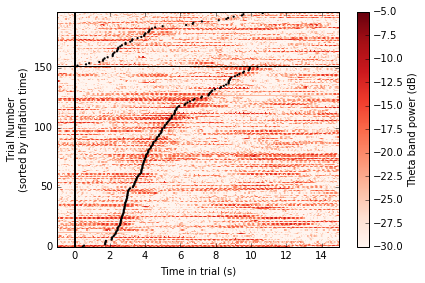

In [11]:
# make coordinates
trials = np.arange(events_lfp.shape[1])
yy, xx = np.meshgrid(trials, events_lfp.index)

plt.pcolormesh(xx, yy, events_lfp.values, cmap='Reds', vmin=-30, vmax=-5, rasterized=True);
plt.colorbar(label='Theta band power (dB)');
plt.scatter(evt_sorted['inf_dur'], trials, marker='o', color='k', s=5, edgecolors='none');
plt.xlim(Tpre, Tpost);
plt.ylim(trials[0], trials[-1]);
plt.plot((0, 0), (trials[0], trials[-1]), color='k', linewidth=2);
plt.ylabel('Trial Number\n(sorted by inflation time)')
plt.xlabel('Time in trial (s)')
plt.axhline(y=nstops, color='k', zorder=1);
plt.tight_layout()

plt.savefig("figures/power_channel_raster.svg")